<a href="https://colab.research.google.com/github/Hristo2076/ml_processes/blob/main/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Цель:** применить на практике базовые ансамблевые методы

In [45]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,StackingClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

1. Получите данные и загрузите их в рабочую среду. (Jupyter Notebook или другую)

In [47]:
heart = pd.read_csv('heart.csv')
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [48]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [49]:
heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


2. Подготовьте датасет к обучению моделей.
  1. Категориальные переменные переведите в цифровые значения. Можно использовать pd.get_dummies, preprocessing.LabelEncoder. Старайтесь не использовать для этой задачи циклы.
  2. *Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака).

In [50]:
col = heart.select_dtypes('object').columns
col

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

In [51]:
heart.ChestPainType.value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64

In [52]:
heart.RestingECG.value_counts()

Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64

In [53]:
heart.ExerciseAngina.value_counts()

N    547
Y    371
Name: ExerciseAngina, dtype: int64

In [54]:
heart.ST_Slope.value_counts()

Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64

In [55]:
heart.Sex = LabelEncoder().fit_transform(heart.Sex)
heart.ExerciseAngina = LabelEncoder().fit_transform(heart.ExerciseAngina)
heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,0,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,1,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,0,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,1,NAP,150,195,0,Normal,122,0,0.0,Up,0


In [57]:
ohe = pd.get_dummies(heart[['ChestPainType','RestingECG','ST_Slope']],drop_first=True)
heart = pd.concat([heart,ohe],axis=1)
heart.drop(['ChestPainType','RestingECG','ST_Slope'],axis=1,inplace=True,)
heart.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,...,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,1,...,0,0,1,1,0,0,1,0,0,1
1,49,0,160,180,0,156,0,1.0,1,0,...,0,1,0,0,1,0,1,0,1,0
2,37,1,130,283,0,98,0,0.0,0,1,...,1,0,1,1,0,0,0,1,0,1
3,48,0,138,214,0,108,1,1.5,1,0,...,0,1,0,0,0,0,1,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,...,0,0,1,0,1,0,1,0,0,1


<Axes: >

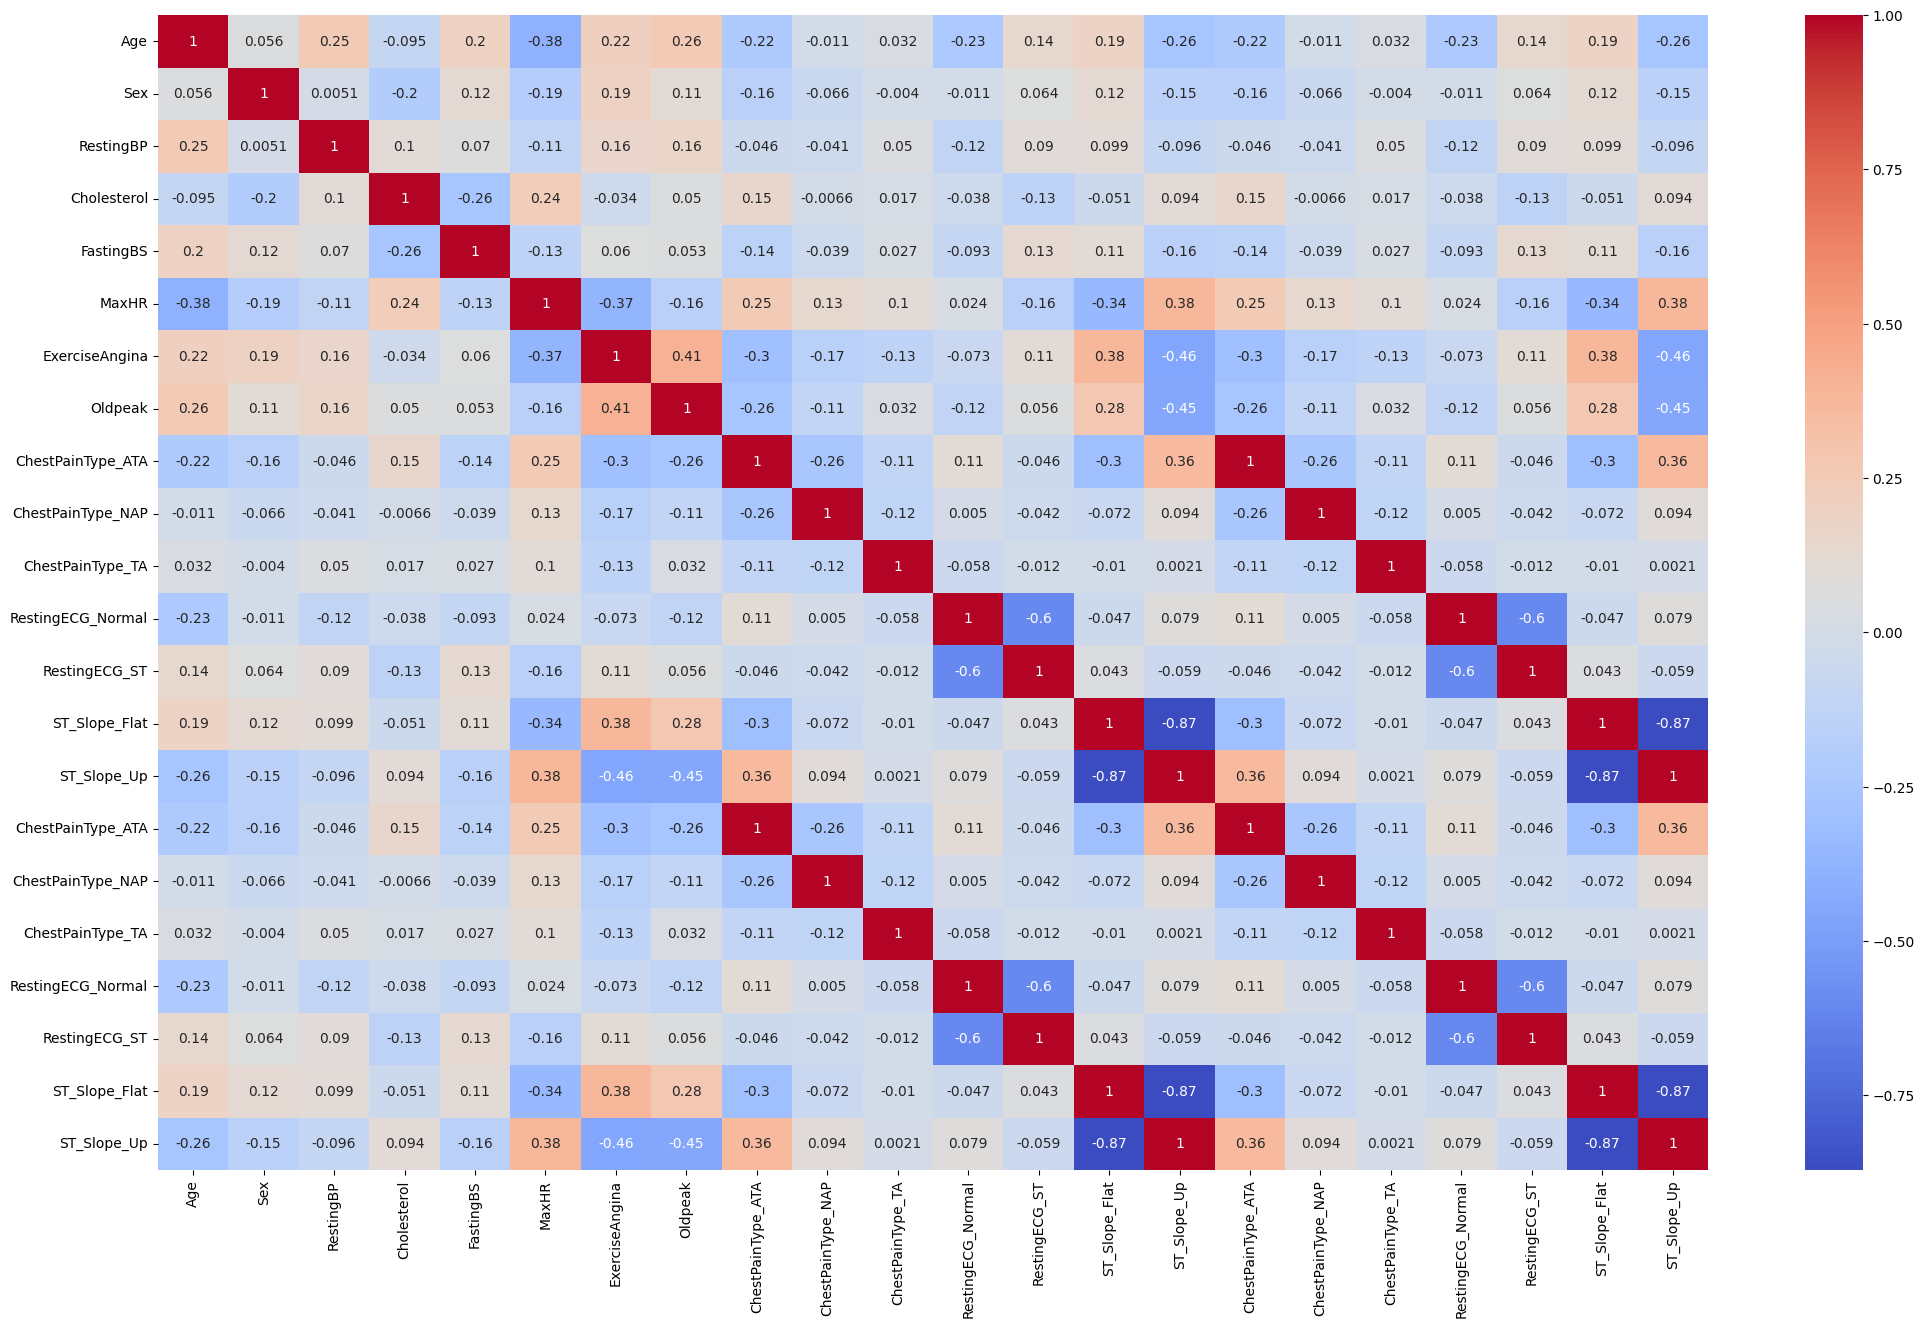

In [63]:
correlation = heart.drop('HeartDisease',axis=1).corr()
plt.figure(figsize = (25,15))
sns.heatmap(correlation, annot = True,cmap='coolwarm')

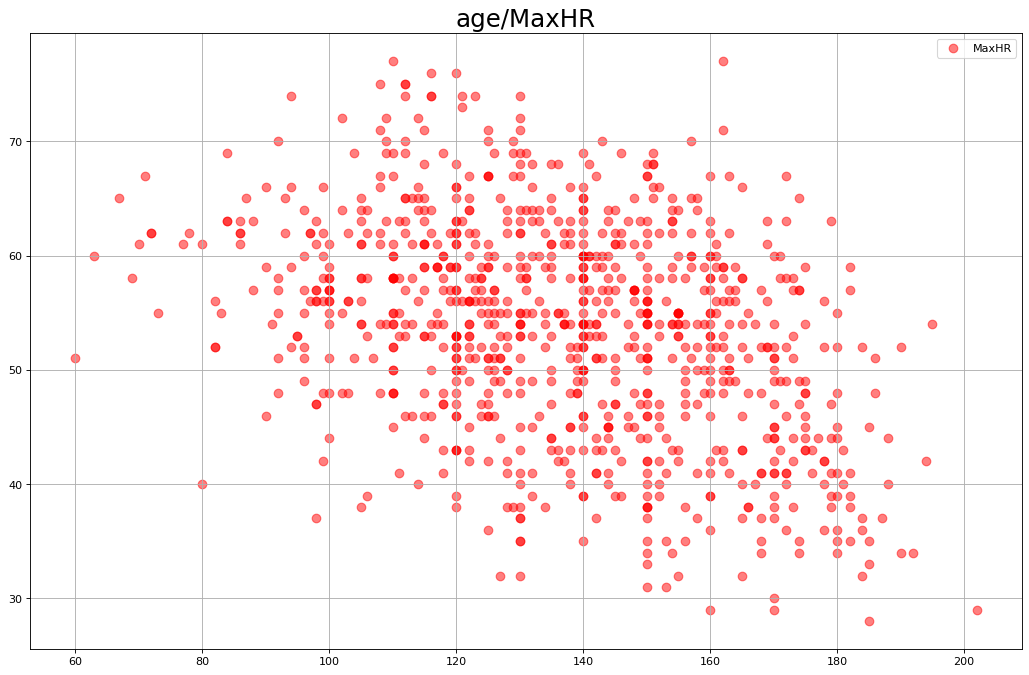

In [100]:

fig, ax = plt.subplots(figsize=(16,10), dpi= 80)    
plt.scatter(heart.MaxHR,heart.Age,
            s=60,
            alpha=0.5,
            color='r',
            label='MaxHR')

# Decorations
plt.grid()
plt.title('age/MaxHR', fontsize=22)
plt.legend(loc='upper right',)
plt.show()

3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [101]:
X = heart.drop('HeartDisease',axis=1)
y = heart.HeartDisease

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 random_state=42,
                                                 test_size=0.25)


4. Обучите дерево решений на обучающем множестве. Используйте следующие модели:
  1. tree.DecisionTreeClassifier
  2. ensemble.RandomForestClassifier

In [105]:
clf_rf = RandomForestClassifier(random_state=10,
                                max_depth=5,
                                min_samples_split=3)
clf_rf.fit(X_train, y_train)

tre_clas = DecisionTreeClassifier(random_state=10,
                                  max_depth=5,
                                  min_samples_split=3
                                  )
tre_clas.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=3, random_state=10)

5. Для тестового множества сделайте предсказание целевой переменной. Выведите метрики для каждой построенной модели с помощью metrics.classification_report.

In [106]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
y_pred_tree = tre_clas.predict(X_test)
print(classification_report(y_test, y_pred_tree, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.74      0.83      0.78        98
     class 1       0.86      0.78      0.82       132

    accuracy                           0.80       230
   macro avg       0.80      0.80      0.80       230
weighted avg       0.81      0.80      0.80       230



In [107]:
y_pred_rf = clf_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.83      0.83      0.83        98
     class 1       0.87      0.87      0.87       132

    accuracy                           0.85       230
   macro avg       0.85      0.85      0.85       230
weighted avg       0.85      0.85      0.85       230



6. Выведите важность признаков, полученную после обучения модели из п. 4b в виде столбчатой диаграммы. Отсортируйте важность по убыванию.

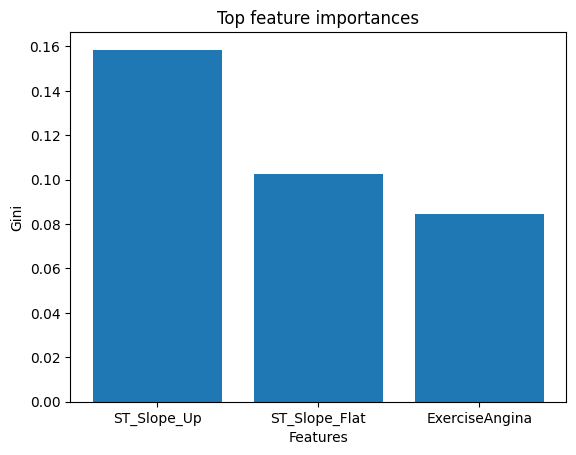

In [109]:
imp = pd.Series(clf_rf.feature_importances_)
imp.index = pd.Series(X_train.columns)

imp = imp.sort_values(ascending=False)

plt.title('Top feature importances')
plt.xlabel('Features')
plt.ylabel('Gini')
plt.bar(imp.head().index, imp.head())
plt.show()

7. Обучите бэггинг над моделью из п. 4a. Используйте ensemble.BaggingClassifier.
  1. Повторите п. 5

In [115]:
bagging = BaggingClassifier(tre_clas,
                           n_estimators=10,
                           max_samples=0.5,
                           max_features=0.5,
                           random_state=10)

bagging.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5,
                                                   min_samples_split=3,
                                                   random_state=10),
                  max_features=0.5, max_samples=0.5, random_state=10)

In [116]:
y_pred_bag = bagging.predict(X_test)

print(classification_report(y_test, y_pred_bag, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.78      0.85      0.81        98
     class 1       0.88      0.82      0.85       132

    accuracy                           0.83       230
   macro avg       0.83      0.83      0.83       230
weighted avg       0.83      0.83      0.83       230



8. Обучите стекинг трех моделей: из п. 4a, п. 4b и svm.LinearSVC. Используйте ensemble.StackingClassifier.
  1. Повторите п. 5

In [122]:
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVC

Class = StackingClassifier(
    [
        ('RandomForest', clf_rf),
        ('DecisionTree', tre_clas),
        ('SVM', LinearSVC())
    ])
Class.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

StackingClassifier(estimators=[('RandomForest',
                                RandomForestClassifier(max_depth=5,
                                                       min_samples_split=3,
                                                       random_state=10)),
                               ('DecisionTree',
                                DecisionTreeClassifier(max_depth=5,
                                                       min_samples_split=3,
                                                       random_state=10)),
                               ('SVM', LinearSVC())])

In [123]:
y_pred_st= Class.predict(X_test) 
print(classification_report(y_test, y_pred_st, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.85      0.81      0.83        98
     class 1       0.86      0.89      0.88       132

    accuracy                           0.86       230
   macro avg       0.86      0.85      0.85       230
weighted avg       0.86      0.86      0.86       230



9. Сформулируйте выводы по проделанной работе.
  1. Сравните метрики построенных моделей.
  2. Напишите свое мнение, какая модель наилучшая и почему.

In [127]:
res = []
for i in Class.named_estimators:
   res.append(Class.named_estimators_[i].score(X_test, y_test))
res

[0.8521739130434782, 0.8, 0.7956521739130434]

In [128]:
data = {'model_rf':clf_rf.score(X_test,y_test),
        'model_tree':tre_clas.score(X_test,y_test),
        'SVM_model': res[-1],
        }

res = pd.DataFrame(data=data,index=range(1))
res
     


,model_rf,model_tree,SVM_model
0,0.852174,0.8,0.795652


Исходя из результатов `score` видно что ,хоть и не на много, но модель `DecisionTree` лучше модели `LinearSVC`. Э то обьясняется тем , что деревья решений лучше для категориальных данных, и это обеспечивает колинеарность лучше, чем SVM.